# An Evaluation of Naive Bayesian Anti-Spam Filtering
<b>Authors:</b> John Caingles, Kingston Koa and Jolo Simeon
<hr>
## Description
A tutorial for the reimplementation of the paper with the same name by Ion Androutsopoulos, John Koutsias, Konstantinos  Chandrinos, George Paliouras and Constantine Spyropoulos (2000). It uses a Naive Bayesian classifier to filter spam e-mails on a corpus found in the emails folder. The effect of attribute size, lemmatization and the use of stop-lists, among other variables, on the performance of the filter is explored.

<hr>
## Preparing the Tests
For each test, we perform a ten-fold cross-validation. This means that out of the 10 folders, one is selected and the nine others are used as training data. This is iterated for each of the folders and the averages of the results are computed.

For each test, we set the attirbute size(<attrib var>), threshold lambda(<lambda var>), and which data sets are to be used (<file directory var>)  depending on what is required. In this example, the blah blah is set to 0 because divsion by 0 is LIFE!!!!!!!!!!

In [ ]:
x = 0
y = 0
z = 0

For each iteration, we also intialize the following variables to enable the filter to be retrained on the data set required and for the results to be recalculated.

In [ ]:
words_dic.clear()
attrib_dic.clear()

## Training the Filter
The filter is then trained using the e-mails from the 9 folders. For each message, regular expressions are used to obtain only the words without any unwanted characters and the letters are all changed to lowercase. 

In [ ]:
def getWordsFromEmail(content):
    content = re.sub('[^a-zA-Z]+', ' ', content)
    content = content.lower()
    return content.split()

We can now use the resulting array of words to train the filter. We do this by adding it to a dictionary, named words_dic, whose key is a string, which is the word and the value is a Word object. 

In [ ]:
def train(content, email_type):
    allwords_array = getWordsFromEmail(content)
    words_array = set(allwords_array)
    for word in words_array:
        word_obj = words_dic.get(word, None)
        if word_obj is None:
            word_obj = Word()
            word_obj.setContent(word)

        if email_type == 'spam':
            word_obj.addToSpamOccur(1)
        else:
            word_obj.addToHamOccur(1)
        words_dic[word] = word_obj

In [ ]:
class Word:
    def __init__(self):
        self.spamOccurence = 0
        self.hamOccurence = 0
        self.spamProbability = 0.0
        self.hamProbability = 0.0
        self.content = ''
        self.mutualInfo = 0.0

## Selecting Attributes
To select attributes among all the words, only the top <i>n</i> (n being the variable attrib_size) attributes with the highest mutual information (MI) will be chosen. We added exception handling to estimate the computation in case of a very small value which may lead to a ValueError.

In [ ]:
def computeMI():
    total = ham_count + spam_count
    for key, value in words_dic.iteritems():
        spam_occur = value.getSpamOccur()
        spam_notoccur = spam_count - spam_occur
        ham_occur = value.getHamOccur()
        ham_notoccur = total - value.getHamOccur()
        try:
            mutual_info = (spam_occur / total) * math.log((total * spam_occur) / 
                                                          ((spam_occur + ham_occur) * (spam_occur + spam_notoccur)))
        except:
            mutual_info = 0.0
        try:
            mutual_info += (spam_notoccur / total) * math.log((total * spam_notoccur) / 
                                                              ((spam_notoccur + ham_notoccur) * (spam_occur + spam_notoccur)))
        except:
            mutual_info += 0.0
        try:
            mutual_info += (ham_occur / total) * math.log((total * ham_occur) / 
                                                          ((spam_occur + ham_occur) * (ham_occur + ham_notoccur)))
        except:
            mutual_info += 0.0
        try:
            mutual_info += (ham_notoccur / total) * math.log((total * ham_notoccur) / 
                                                             ((spam_notoccur + ham_notoccur) * (ham_occur + ham_notoccur)))
        except:
            mutual_info += 0.0
        words_dic[key].setMutualInfo(mutual_info)

In [ ]:
def getTopAttribs(n):
    sorted_dic = sorted(words_dic.values(), key=lambda word: word.mutualInfo, reverse=True)
    top_n = sorted_dic[:n]
    for word in top_n:
        attribs_dic[word.getContent()] = word
    return attribs_dic

## Testing using Naive Bayes
After we have chosen the attributes, we can then proceed to classifying the e-mails (the test folder). We calculate for the probability that an e-mail is spam based on Bayes' theorem. We use the data that we collected during the training to compute for the probabilities needed.

In [ ]:
def computeProbabilityForListOfWords(attribs_dic, word_list, email_type):
    answer = 1.0
    for word, word_obj in attribs_dic.iteritems():
        isWordIncluded = False
        for word_list_word in word_list:
            if word == word_list_word:
                isWordIncluded = True
        multiplicand = 1.0
        if email_type == 'spam':
            multiplicand = word_obj.getSpamProbability()
        else:
            multiplicand = word_obj.getHamProbability()

        if isWordIncluded is False:
            multiplicand = 1.0 - multiplicand
        answer = answer * multiplicand
    return answer

In [ ]:
def computeBayesianProbability(spam_prob, ham_prob, word_spam_prob, word_ham_prob, email_type):

    if email_type is 'spam':
        return (word_spam_prob * spam_prob) / (word_spam_prob * spam_prob + word_ham_prob * ham_prob )
    else:
        return (word_ham_prob * ham_prob) / (word_ham_prob * ham_prob + word_spam_prob * spam_prob)

In [ ]:
def testEmail(test_email):
    email_file = open(test_email, "r")
    content = email_file.read()
    word_list = getWordsFromEmail(content)
    word_list = set(word_list)  # remove duplicates
    word_spam_prob = bae.computeProbabilityForListOfWords(attribs_dic, word_list, "spam")
    word_ham_prob = bae.computeProbabilityForListOfWords(attribs_dic, word_list, "ham")
    email_type = "spam"

    baye_probability = bae.computeBayesianProbability(SPAM_PROBABILITY, HAM_PROBABILITY, word_spam_prob, word_ham_prob,
                                                      email_type)
    checkSpamHam(threshold_lambda, baye_probability)

The classification is not finished here, as how can we conclude that an e-mail is spam or ham depending on the probability? We use a threshold, lambda, which is defined as how much more times is classifying a ham e-mail as spam more costly than classifying a spam e-mail as ham.

In [ ]:
def checkSpamHam(threshold, prob_spam):
    t = threshold / (threshold + 1)
    if (prob_spam > t):
        return 'spam'
    return 'ham'

## Results

In [4]:
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=[1, 2, 3, 4, 5, 
       6, 7, 8, 9, 10,
       11, 12, 13, 14, 15],
    y=[10, 20, None, 15, 10,
       5, 15, None, 20, 10,
       10, 15, 25, 20, 10],
    name = '<b>No</b> Gaps', # Style name/legend entry with html tags
    connectgaps=True
)
trace2 = go.Scatter(
    x=[1, 2, 3, 4, 5,
       6, 7, 8, 9, 10,
       11, 12, 13, 14, 15],
    y=[5, 15, None, 10, 5,
       0, 10, None, 15, 5,
       5, 10, 20, 15, 5],
    name = 'Gaps',
)

data = [trace1, trace2]

fig = dict(data=data)
py.iplot(fig, filename='simple-connectgaps')


ImportError: No module named plotly

In [1]:
%matplotlib inline

In [2]:
from pylab import *

In [3]:
x = linspace(0, 5, 10)
y = x ** 2

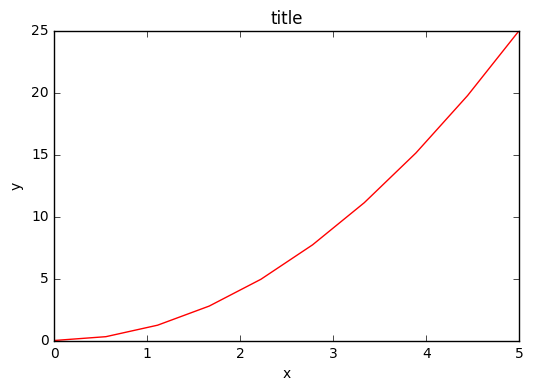

In [4]:
figure()
plot(x, y, 'r')
xlabel('x')
ylabel('y')
title('title')
show()